In [44]:
import time
import h5py
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
print(f"PyTorch version: {torch.__version__}")
print(f"Numpy version: {np.__version__}")

PyTorch version: 2.1.2+cu118
Numpy version: 1.24.1


In [4]:
def load_data():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [5]:
# Loading the data (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_data()

In [6]:
train_set_x_orig.shape, test_set_x_orig.shape

((209, 64, 64, 3), (50, 64, 64, 3))

In [7]:
train_set_y.shape

(1, 209)

y = [0], it's a 'non-cat' picture.


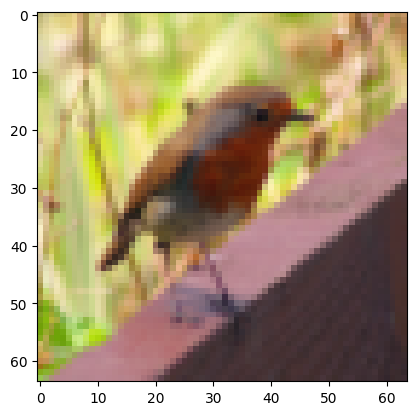

In [8]:
# Example of a picture
index = 10
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [1], it's a 'cat' picture.


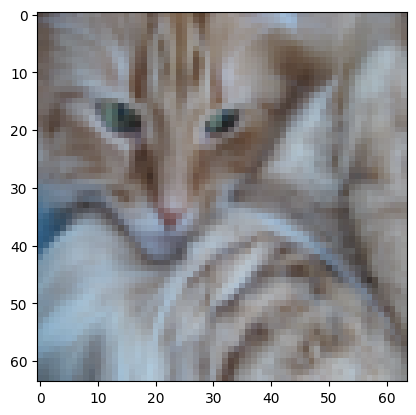

In [9]:
# Example of a picture
index = 2
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [10]:
### START CODE HERE ### (≈ 3 lines of code)
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]
### END CODE HERE ###

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [11]:
X_train = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1) / 255.0
X_test = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1) / 255.0

X_train.shape, X_test.shape 

((209, 12288), (50, 12288))

In [14]:
y_train, y_test = np.squeeze(train_set_y), np.squeeze(test_set_y)
y_train.shape, y_test.shape

((209,), (50,))

In [17]:
# set the device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [16]:
# let's define the model

class CatModel(nn.Module):
    
    def __init__(self, input_features, output_features, hidden_units1, hidden_units2, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
        self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_units1)
        self.layer2 = nn.Linear(in_features=hidden_units1, out_features=hidden_units2)
        self.layer3 = nn.Linear(in_features=hidden_units2, out_features=output_features)
    
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        
        # Final layer (logits, no activation as BCEWithLogitsLoss expects raw logits)
        x = self.layer3(x)
        
        return x

In [19]:
X_train = torch.from_numpy(X_train).type(torch.float).to(device)
X_test = torch.from_numpy(X_test).type(torch.float).to(device)
y_train = torch.from_numpy(y_train).type(torch.float).to(device)
y_test = torch.from_numpy(y_test).type(torch.float).to(device)

In [20]:
X_train

tensor([[0.0667, 0.1216, 0.2196,  ..., 0.0000, 0.0000, 0.0000],
        [0.7686, 0.7529, 0.7451,  ..., 0.3216, 0.3137, 0.3176],
        [0.3216, 0.2784, 0.2667,  ..., 0.5412, 0.5529, 0.5569],
        ...,
        [0.5608, 0.6078, 0.6471,  ..., 0.3333, 0.4196, 0.5843],
        [0.0863, 0.0941, 0.0902,  ..., 0.0157, 0.0196, 0.0000],
        [0.0314, 0.1098, 0.2078,  ..., 0.0000, 0.0000, 0.0000]],
       device='cuda:0')

In [21]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [22]:
def plot_loss_curves(epochs, train_loss_values, test_loss_values):
    # Create a figure with size 6x4 inches
    plt.figure(figsize=(6, 4))
    
    # Plot the training and test loss values
    plt.plot(range(epochs), train_loss_values, label="Train loss")
    plt.plot(range(epochs), test_loss_values, label="Test loss")
    
    # Set the title and labels
    plt.title("Training and Test Loss Curves")
    plt.ylabel("Loss")
    plt.xlabel("Epochs")
    
    # Add a legend
    plt.legend()
    
    # Add a grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

In [24]:
# let's define the training loop

def training_loop(X_train, y_train, X_test, y_test, loss_fn, optimizer, n_iterations, model):
    
    # Create empty loss lists to track values
    train_loss_values = []
    test_loss_values = []
    
    # Build training and evaluation loop
    for epoch in range(n_iterations):
        ### Training
        model.train()

        # 1. Forward pass (model outputs raw logits)
        y_logits = model(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
    
        # 2. Calculate loss/accuracy
        # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
        #                y_train) 
        loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                    y_train) 
        
        acc = accuracy_fn(y_true=y_train, 
                        y_pred=y_pred) 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backwards
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        ### Testing
        model.eval()
        
        with torch.inference_mode():
            # 1. Forward pass
            test_logits = model(X_test).squeeze() 
            test_pred = torch.round(torch.sigmoid(test_logits))
            # 2. Caculate loss/accuracy
            test_loss = loss_fn(test_logits,
                                y_test)
            test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)

        # Print out what's happening every 500 epochs
        if (epoch % 500 == 0):
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")
        
                # Save the loss values (move them to CPU before converting to NumPy)
        train_loss_values.append(loss.detach().cpu().numpy())
        test_loss_values.append(test_loss.detach().cpu().numpy())
    
    return train_loss_values, test_loss_values

In [34]:
model = CatModel(input_features=X_train.shape[1],
                    output_features=1,
                    hidden_units1=8,
                    hidden_units2=4).to(device)

model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0078, -0.0058,  0.0033,  ..., -0.0021, -0.0070,  0.0016],
                      [ 0.0060, -0.0048, -0.0014,  ..., -0.0080, -0.0051,  0.0004],
                      [-0.0037, -0.0069,  0.0053,  ..., -0.0039,  0.0087,  0.0015],
                      ...,
                      [ 0.0040, -0.0029, -0.0042,  ..., -0.0080, -0.0006, -0.0023],
                      [ 0.0084,  0.0082,  0.0008,  ..., -0.0008,  0.0070,  0.0009],
                      [-0.0048,  0.0085, -0.0037,  ..., -0.0082, -0.0070,  0.0054]],
                     device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.0071, -0.0020,  0.0048, -0.0070,  0.0057,  0.0023,  0.0021,  0.0081],
                     device='cuda:0')),
             ('layer2.weight',
              tensor([[-0.3243,  0.2848,  0.0919,  0.2850, -0.0787,  0.3021,  0.3332, -0.0941],
                      [-0.0141,  0.3057, -0.1835,  0.0826, -0.1513, -0.0919,  0.0415, -0.1468],
          

In [29]:
n_iterations = 8000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.SGD(
                                    params=model.parameters(),
                                    lr=0.001
                                ),
                                n_iterations=n_iterations, 
                                model=model)

Epoch: 0 | Loss: 0.64728, Accuracy: 65.55% | Test loss: 0.81510, Test acc: 34.00%

Epoch: 500 | Loss: 0.63004, Accuracy: 65.55% | Test loss: 0.81276, Test acc: 34.00%

Epoch: 1000 | Loss: 0.60926, Accuracy: 65.55% | Test loss: 0.78899, Test acc: 34.00%

Epoch: 1500 | Loss: 0.58389, Accuracy: 66.03% | Test loss: 0.76116, Test acc: 34.00%

Epoch: 2000 | Loss: 0.55301, Accuracy: 67.46% | Test loss: 0.72664, Test acc: 38.00%

Epoch: 2500 | Loss: 0.51588, Accuracy: 74.64% | Test loss: 0.68910, Test acc: 54.00%

Epoch: 3000 | Loss: 0.47246, Accuracy: 78.47% | Test loss: 0.65297, Test acc: 58.00%

Epoch: 3500 | Loss: 0.42246, Accuracy: 84.21% | Test loss: 0.61967, Test acc: 66.00%

Epoch: 4000 | Loss: 0.36832, Accuracy: 89.00% | Test loss: 0.59722, Test acc: 64.00%

Epoch: 4500 | Loss: 0.31372, Accuracy: 89.95% | Test loss: 0.58705, Test acc: 70.00%

Epoch: 5000 | Loss: 0.26186, Accuracy: 93.30% | Test loss: 0.59369, Test acc: 72.00%

Epoch: 5500 | Loss: 0.21493, Accuracy: 94.74% | Test loss:

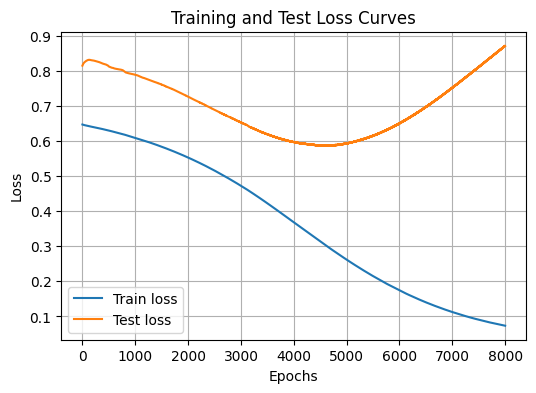

In [30]:
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [39]:
# let's use RMSProp as the optimizer

model = CatModel(input_features=X_train.shape[1],
                    output_features=1,
                    hidden_units1=8,
                    hidden_units2=4).to(device)

n_iterations = 4000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.RMSprop(
                                    params=model.parameters(),
                                    alpha=0.9,
                                    lr=0.0001
                                ),
                                n_iterations=n_iterations, 
                                model=model)

Epoch: 0 | Loss: 0.70377, Accuracy: 35.41% | Test loss: 0.82056, Test acc: 34.00%

Epoch: 500 | Loss: 0.41120, Accuracy: 87.08% | Test loss: 0.72625, Test acc: 58.00%

Epoch: 1000 | Loss: 0.32522, Accuracy: 92.82% | Test loss: 0.77356, Test acc: 56.00%

Epoch: 1500 | Loss: 0.28618, Accuracy: 95.22% | Test loss: 0.82265, Test acc: 64.00%

Epoch: 2000 | Loss: 0.22815, Accuracy: 97.13% | Test loss: 1.03430, Test acc: 56.00%

Epoch: 2500 | Loss: 0.20509, Accuracy: 97.61% | Test loss: 1.16982, Test acc: 54.00%

Epoch: 3000 | Loss: 0.18938, Accuracy: 98.09% | Test loss: 1.12423, Test acc: 68.00%

Epoch: 3500 | Loss: 0.17654, Accuracy: 100.00% | Test loss: 1.45458, Test acc: 56.00%



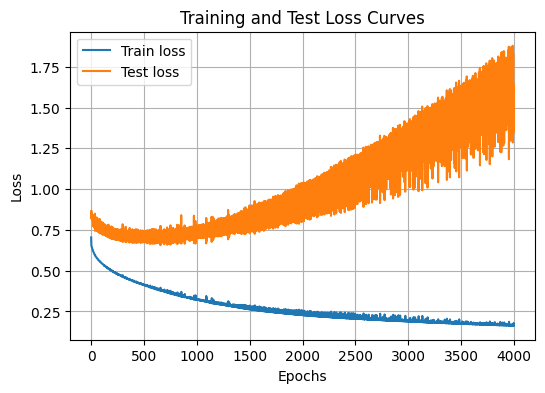

In [41]:
# RMSProp optimizer
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [47]:
%%time

# let's use Adam as the optimizer

model = CatModel(input_features=X_train.shape[1],
                    output_features=1,
                    hidden_units1=8,
                    hidden_units2=4).to(device)

n_iterations = 4000

train_loss, test_loss = training_loop(
                                X_train=X_train,
                                y_train=y_train,
                                X_test=X_test,
                                y_test=y_test,
                                loss_fn=nn.BCEWithLogitsLoss(),
                                optimizer=torch.optim.Adam(
                                    params=model.parameters(),
                                    betas=(0.9, 0.999),
                                    lr=0.0001
                                ),
                                n_iterations=n_iterations, 
                                model=model)

Epoch: 0 | Loss: 0.68915, Accuracy: 56.46% | Test loss: 0.75017, Test acc: 34.00%

Epoch: 500 | Loss: 0.32468, Accuracy: 91.87% | Test loss: 0.84087, Test acc: 48.00%

Epoch: 1000 | Loss: 0.26057, Accuracy: 97.61% | Test loss: 1.03067, Test acc: 44.00%

Epoch: 1500 | Loss: 0.23678, Accuracy: 98.09% | Test loss: 1.17162, Test acc: 46.00%

Epoch: 2000 | Loss: 0.22202, Accuracy: 98.09% | Test loss: 1.34120, Test acc: 44.00%

Epoch: 2500 | Loss: 0.21236, Accuracy: 98.09% | Test loss: 1.40567, Test acc: 46.00%

Epoch: 3000 | Loss: 0.20398, Accuracy: 98.09% | Test loss: 1.45181, Test acc: 50.00%

Epoch: 3500 | Loss: 0.19661, Accuracy: 98.09% | Test loss: 1.54177, Test acc: 48.00%

CPU times: total: 3.33 s
Wall time: 16.5 s


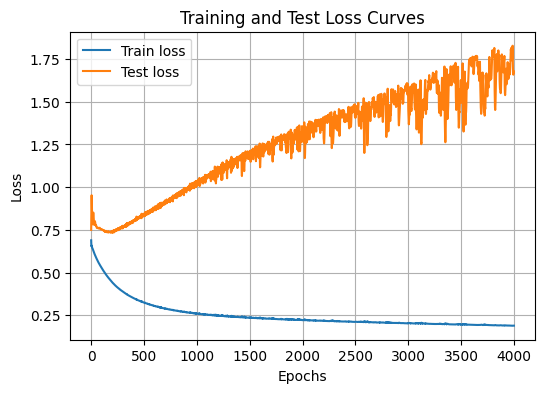

In [48]:
# Adam optimizer
plot_loss_curves(epochs=n_iterations, train_loss_values=train_loss,
                    test_loss_values=test_loss)

In [49]:
model.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.0066, -0.0055,  0.0045,  ..., -0.0034,  0.0084, -0.0090],
                      [-0.0079,  0.0169, -0.0018,  ...,  0.0138,  0.0186, -0.0313],
                      [ 0.0056,  0.0043, -0.0074,  ...,  0.0028,  0.0044, -0.0026],
                      ...,
                      [-0.0025,  0.0011, -0.0045,  ...,  0.0045, -0.0057, -0.0077],
                      [-0.0162,  0.0096,  0.0041,  ..., -0.0087,  0.0176, -0.0364],
                      [-0.0098,  0.0259,  0.0040,  ..., -0.0089,  0.0108, -0.0499]],
                     device='cuda:0')),
             ('layer1.bias',
              tensor([ 0.0007,  0.0375, -0.0049, -0.0023,  0.0567, -0.0005,  0.0307,  0.0332],
                     device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.0184,  0.3343, -0.1274,  0.3368,  0.6113,  0.2365,  0.0285,  0.3318],
                      [ 0.2080, -0.2102, -0.2905,  0.3225, -0.2138, -0.3473, -0.1676, -0.1760],
          